

# Weryfikacja wpływu pełni księżyca na narodziny dzieci

***

    autor: Michał Łazarczyk

***

## Wprowadzenie
W rozmowach z kobietami w ciąży przewija się stwierdzenie, jakoby pełnia księżyca miała sprzyjać rozpoczęciu akcji porodowej. Stwierdzenie to przybiera też formę anegdotki mówiącej o tym, że doświadczenie położnicy starają się uniknąć dyżuru w pełnię księżyca. 

Brak naukowego wyjaśnienia mechanizmu rzekomego wpływu księżyca nie przeszkadza mnożyć się rozmaitym teoriom odwołującym się do zbliżonego czasu trwania cyklu miesięcznego kobiety i lunarnego miesiąca, faktu, że ciąża statystycznie trwa 9 miesięcy kalendarzowych a 10 lunarnych, czy nawet odwołując się do pływów oceanów i mórz spowodowancyh zmianą położenia księżyca i potencjalnie podobnego wpływu księżyca na wody płodowe.

Celem tego opracowania jest zweryfikowanie istnienia jakiejkolwiek korelacji między fazami księżyca a ilością porodów.

## Dane źródłowe
Ze względu na dostępność wykorzystano dane ze Stanów Zjednoczonych z okresu 1995-2004.
Dane są zawarte w dwóch plikach:

`US_births_1994-2003_CDC_NCHS.csv` zawiera dane o urodzeniach w latach 1994 do 2003 zebrane przez _"Centers for Disease Control"_ oraz _"Prevention's National Center for Health Statistics"_

`US_births_2000-2014_SSA.csv` zawiera dane o urodzeniach w latach 2000 do 2004 zebrane przez _"Social Security Administration"_

Obydwa pliki mają następującą strukturę:


Nagłówek | Definicja
---|---------
`year` | Rok
`month` | miesiąc
`date_of_month` | Numer dnia w miesiącu
`day_of_week` | Numer dnia tygodnia, gdzie 1 to poniedziałek, a 7 to niedziele
`births` | liczba urodzin

Seria pomiarowa powstała poprzez złożenie danych za lata 1994-1999 z pierwszego pliku oraz za lata 2000-2014 z drugiego pliku
pliki z danymi źródłowymi stanowią załącznik do tego dokumentu


## Opis metod analizy

### Obróbka wstępna danych źródłowych
Dane źródłowe są uzupełnione o numer dnia w dodanej kolumnie `day no.` w całej serii pomiarowej, gdzie dzień 0 to 1.01.1994, a 7669 to 31.12.2014 
W dalszych działaniach kolumna 'Numer dnia' reprezentuje dziedzinę czasu dla danych źródłowych.


### Metody analizy danych źródłowych
1. Test t Studenta dla prób niezależnych
Ten rodzaj testu t Studenta jest chyba najczęściej stosowaną metodą statystyczną w celu porównania średnich z dwóch niezależnych od siebie grup.Wykorzystujemy go gdy chcemy porównać dwie grupy pod względem jakiejś zmiennej ilościowej. Na przykład gdy chcemy porównać ilość wypalanych miesięcznie papierosów w grupie kobiet i mężczyzn, albo w przypadku chęci porównania powierzchni mieszkania mierzonej w metrach kwadratowych między mieszkańcami Wrocławia i Gdańska.

2. Analiza widma częstotliwościowego
Powszechnie stosowaną w technice metodą odwzorowywania sygnałów czasowych w dziedzinie częstotliwości jest _transformacja Fouriera_ [1]. Podejście takie pozwoli na zweryfikowanie, czy w częstotliwościach zmiany ilości urodzeń znajdują się częstotliwości odpowiadające cyklowi lunarnemu.
Cykl faz księżyca trwa 29 dni 12 godzin 44 minuty i 2,8 sekundy - na potrzeby tego opracowania wartość ta zostaje uproszczona do 29 dni &plusmn; 1 dzień. Zatem domniemany wpływ pełni księżyca powinien uwidaczniać się co 29 dni &plusmn; 1 dzień.

Do transformacji danych źródłowych zostanie wykorzystana numeryczna wersja tej metody o nazwie _Fast Fourier Transform (FFT)_ [2].

Przedstawienie widma danych źródłowych w dziedzinie częstotliwości pozwoli ustalić, czy w danych pomiarowych są wartości częstotliwości o wyższym wskaźniku urodzeń, oraz pozwoli określić, czy dla częstotliwości cyklu księżycowego (29) dni wkaźnik urodzeń jest wyższy niż wartość średnia.

Przeprowadzona analiza nie pozwala rozróżnić przypadków faktycznego wpływu księżyca od wpływu efektu placebo


***

Opracowanie zostało zrealizowane w `Jupyter Notebook` pracującym na `Python 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]`


***


[1] [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform)

[2] [FFT - Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)


# Analiza danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn
from astral import Astral
import seaborn
from scipy.stats import ttest_ind
%matplotlib nbagg

##########################################
#          Przygotowanie danych          #
##########################################

# Wczytanie danych źródłowych do DataFrame df i uporządkowanie daty, nr dnia jako indeks
df= pd.DataFrame()
df = pd.read_csv('US_births_1994-2003_CDC_NCHS.csv')
df = df[(df['year'] <=1999)]
df = df.append(pd.read_csv('US_births_2000-2014_SSA.csv'))

# df.set_index(np.arange(1, len(df)+1, 1), inplace=True)
df.reset_index(drop=True, inplace=True)
df.index.name = 'day no.'

df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['date_of_month'].astype(str))
df.drop(['year', 'month', 'date_of_month', 'day_of_week'], inplace=True, axis=1)
a = Astral()

df['moon'] = np.nan
for i, r in df.iterrows():
    if 13 <= a.moon_phase(r['date']) <= 15:
        df.loc[i,'moon'] = 1

## Prezentacja danych

<IPython.core.display.Javascript object>


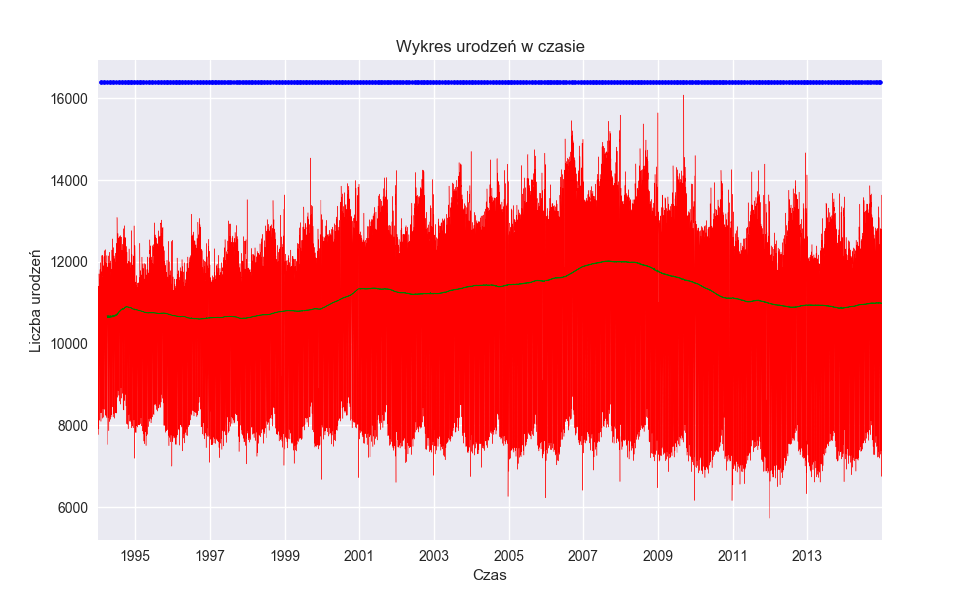


Średnia ilość urodzeń w okresie 1994-2014:
	 W całym okresie: 11175.1
	 W trakcie pełni: 11202.4
	 Różnica: 0.00%


In [2]:
x = df['date']
y = df['births']

# try:
#     plt.close(fig1)
# except NameError:
#     pass
# %matplotlib nbagg

fig1 = plt.figure(figsize=(9.8,6))
ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.set_title('Wykres urodzeń w czasie')
ax1.set_xlabel('Czas')
ax1.set_ylabel('Liczba urodzeń')
ax1.set_xlim(x.iloc[0], x.iloc[-1])

ax1.plot(x, y, linewidth=0.3,  color='red')                              # plot full data
ax1.plot(x, df['moon']*1.02*y.max(), 'bo', markersize=3)                 # mark full moon
ax1.plot(x, y.rolling(365, min_periods=90).mean(), 'g-', linewidth=0.5)  # short term mean value

# Calcualtion of global mean values
year_min = pd.to_datetime(df['date'].values).year.min().astype(str)
year_max = pd.to_datetime(df['date'].values).year.max().astype(str)
print()
print('Średnia ilość urodzeń w okresie {}:'.format(year_min+'-'+year_max))
print('\t W całym okresie: {:.1f}'.format(df['births'].mean()))
print('\t W trakcie pełni: {:.1f}'.format(df[df['moon']==1].mean()['births']))
print('\t Różnica: {:.2f}%'.format(np.abs(df['births'].mean() - df[df['moon']==1].mean()['births'])/ df['births'].mean()))


fig1.show()


Powyższy wykres przedstawia ilość urodzeń w każdym z dni dostępnych w danych źródłowych.

Zielona linia oznacza wartośc średnią w okresie &plusmn;pół roku od danego punktu.
Niebieska linia składa się z punktów oznaczających trzy dni w sąsiedztwie pełni księżyca (widoczne po przybliżeniu)
Wykres jest interaktywny. Do zmiany widoku można użyć jednej z 6 ikonek w lewym dolnym rogu:

    "Domek" 		powrót do widoku całości
    "<-" / "->"     poprzedni, następny widok z historii
    "+" 			kadrowanie (lewym przyciskiem myszy) i zoom (prawym przyciskiem myszy)
    "▢" 			zoom okienkiem



-------------------------



## Test t Studenta
Jest to test statystyczny równości wartości oczekiwanych w dwóch populacjach. Jest uogólnieniem testu t Studenta na populacje o różnych wariancjach. 
Na potrzeby testu dane źródłowe zostały podzielone na dwie odrębne populacje: 
 - porody podczas pełni księżyca (data pełni &plusmn; 1 dzień)
 - porody poza okresem pełni księżyca


Hipoteza zerowa H0:
Średnia liczba porodów podczas pełni jest taka sama jak w pozostałych dniach

Hipoteza alternatywna H1:
podczas pełni dzienna liczba porodów jest większa niż w pozostałym okresie cyklu lunarnego

Jeśli wynik testu t  będzie istotny na poziomie p<0,05 możemy odrzucić hipotezę zerową na rzecz hipotezy alternatywnej.

-------------


In [3]:
df1 = df[df['moon'] == 1].loc[:,'births']
df2 = df[df['moon'] != 1].loc[:,'births']
t = ttest_ind(df1, df2)
deg_fr = (len(df1) - 1)
print('wyniki testu t:')
print(t)

wyniki testu t:
Ttest_indResult(statistic=0.37610755052159484, pvalue=0.70684734630719315)


> Wynik testu t **nie pozwala** na odrzucenie hipotezy H0 i przyjęcie hipotezy H1 na podstawie testu statystycznego.

# Transformata Fouriera danych o urodzeniach i analiza uzyskanego widma

In [4]:
#FFT with magnitude normalized to no of samples
fy = np.fft.fft(y)/len(y)*2

# frequency bins
fx = np.fft.fftfreq(fy.size, 1)

<IPython.core.display.Javascript object>


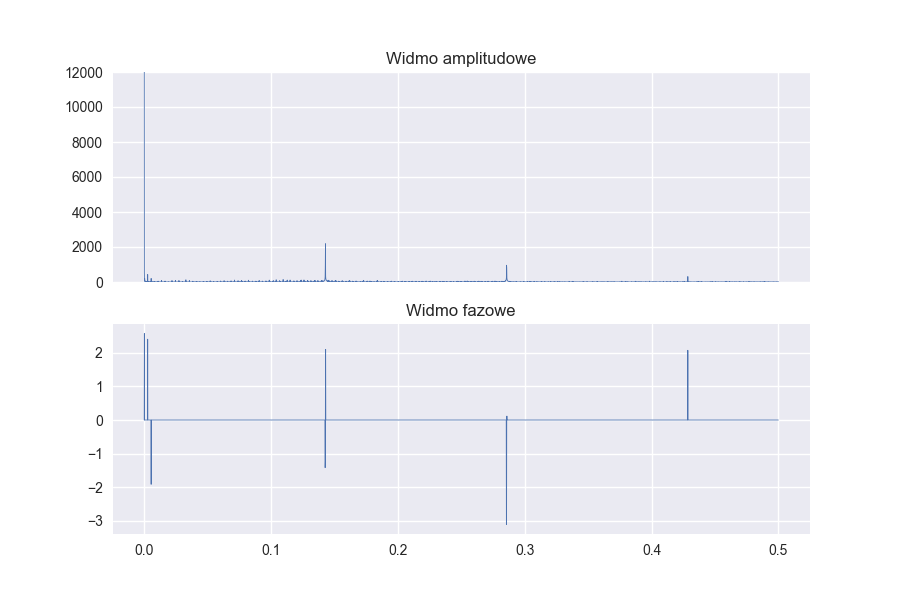

In [5]:
# %matplotlib nbagg
# try:
#     plt.close(spectrum)
# except NameError:
#     pass

spectrum, (amplitude, phase) = plt.subplots(2, sharex=True, figsize=(9,6))
# Magnitude spectrum
amplitude.plot(fx[:len(fx)//2], np.abs(fy)[:len(fy)//2], linewidth=0.6)     # linear scale
# amplitude.semilogy(fx[:len(fx)//2], np.abs(fy)[:len(fy)//2], linewidth=0.6)   # log scale
amplitude.set_title('Widmo amplitudowe')
# amplitude.set_xlim(0,365*2)
amplitude.set_ylim(0, 12e3)

#phase spectrum
fyy = pd.Series(fy).copy()
fyy[(np.abs(fyy)) < (200)] = 0
phase.plot(fx[:len(fx)//2], np.angle(fyy)[:len(fyy)//2], linewidth=0.6)
phase.set_title('Widmo fazowe')
spectrum.show()


-----


O obecności poszczególnych częstotliwości w badanym sygnale świadczą prążki w widmie amplitudowym. Na powyższym wykresie można zaobserwować dwie częstotliwości o znaczących prążkach widma. Obszary te zostały przedstawione
poniżej w powiększeniu. Dodatkowo w powiększeniu przedstawiono też obszar częstotliwości odpowiadający długości cyklu lunarnego.


---------




<IPython.core.display.Javascript object>


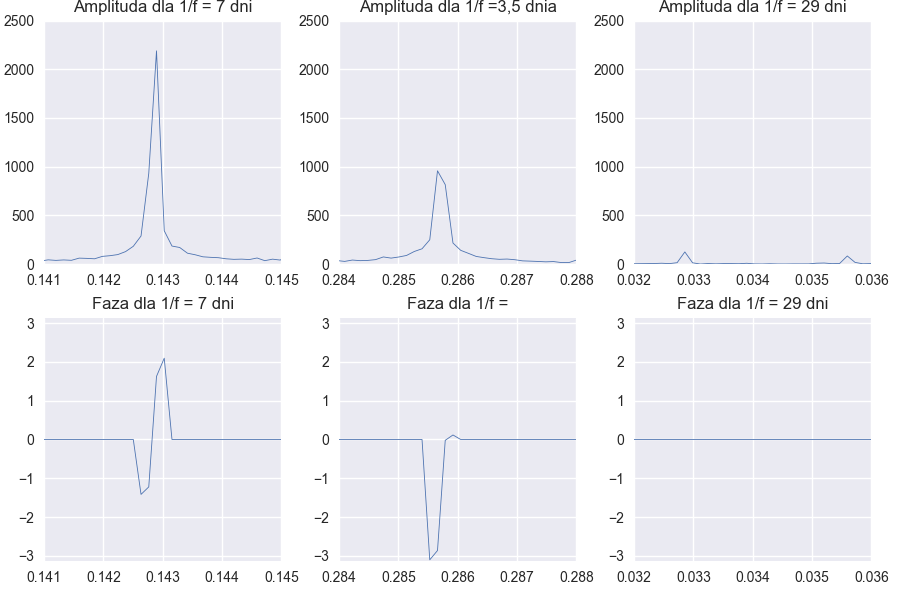

In [6]:
# %matplotlib nbagg
# try:
#     plt.close(details)
# except NameError:
#     pass

details = plt.figure(figsize=(9,6))

m1 = details.add_subplot(231)
m2 = details.add_subplot(232, sharey=m1)
m3 = details.add_subplot(233, sharey=m1)
p1 = details.add_subplot(234, sharex=m1)
p2 = details.add_subplot(235, sharex=m2, sharey=p1)
p3 = details.add_subplot(236, sharex=m3, sharey=p1)
plt.tight_layout()
m1.set_title('Amplituda dla 1/f = 7 dni')
m1.plot(fx[:len(fx)//2], np.abs(fy)[:len(fy)//2], linewidth=0.6)
m1.set_xlim(0.141, 0.145)
m1.set_ylim(0, 2500)

m2.set_title('Amplituda dla 1/f =3,5 dnia')
m2.plot(fx[:len(fx)//2], np.abs(fy)[:len(fy)//2], linewidth=0.6)
m2.set_xlim(0.284, 0.288)


m3.set_title('Amplituda dla 1/f = 29 dni')
m3.plot(fx[:len(fx)//2], np.abs(fy)[:len(fy)//2], linewidth=0.6)
m3.set_xlim(0.032, 0.036)

p1.set_title('Faza dla 1/f = 7 dni')
p1.plot(fx[:len(fx)//2], np.angle(fyy)[:len(fyy)//2], linewidth=0.6)
p1.set_ylim(-np.pi, np.pi)

p2.set_title('Faza dla 1/f =')
p2.plot(fx[:len(fx)//2], np.angle(fyy)[:len(fyy)//2], linewidth=0.6)

p3.set_title('Faza dla 1/f = 29 dni')
p3.plot(fx[:len(fx)//2], np.angle(fyy)[:len(fyy)//2], linewidth=0.6)

plt.subplots_adjust(hspace=0.22)
details.show()



>Widmo jednoznacznie wskazuje na brak prążków odpowiadającym cyklowi lunarnemu. Tym samym hipoteza o wpływie pełni księżyca na ilość porodów zostaje jednoznacznie obalona dla analizowanej próbki danych. Jeżeli rozprzestienie się hipotezy o wpływie księżyca jest ograniczone geograficznie, to dla danych statystycznych z obszarów jej szerokiego rozpowszechnienia może wystąpić prążek w widmie będący wynikiem efektu placebo u rodzących.

>Wyraźnie wybijająca się szpilka dla cyklu 7 dniowego wskazuje na jednoznaczną zależność ilości urodzeń od dnia tygodnia. kolejna szpilka - 3.5 dnia jest tzw. podharmoniczną 7 i najprawdopodobniej jest efektem przecieku widma lub błędów numerycznych algorytmu FFT.

In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')